In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
#path_results = Path('/opt/models/elmo/ner/results (pre queda energia, datalawyer)')
# path_results = Path('/media/discoD/models/elmo/ner/results_embeddings_glove/')
path_results = Path('/media/discoD/models/elmo/ner/elmo_jur/results_final/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/mestrado/results_datalawyer_candidates/datalawyer-ft_ELMo+CNN+GloVe
/media/discoD/models/elmo/ner/mestrado/results_datalawyer_candidates/datalawyer-ft_ELMo+CNN+GloVe-jur
/media/discoD/models/elmo/ner/mestrado/results_datalawyer_candidates/datalawyer-ft_ELMo+GloVe
/media/discoD/models/elmo/ner/mestrado/results_datalawyer_candidates/datalawyer-ft_ELMo+GloVe-jur


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('"%s"' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

40
40


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
CORPUS_TYPE = 'Corpus_Type'
DOMAIN_SPECIFIC = 'Domain_Specific'
DIMENSION = 'Dimension'
EMBEDDING_DIMENSION = 'Embedding_Dimension'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, CORPUS_TYPE, EMBEDDING_TYPE, DOMAIN_SPECIFIC, DIMENSION, EMBEDDING_DIMENSION, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Corpus_Type',
 'Embedding_Type',
 'Domain_Specific',
 'Dimension',
 'Embedding_Dimension',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    embedding = data[2]
    
    if len(data) == 3:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'glove', EMBEDDING_TYPE: 'glove', 
                DOMAIN_SPECIFIC: False, DIMENSION: '300', EXECUTION_NUMBER: data[2],
                CORPUS_TYPE: 'Nilc'}
    elif len(data) == 5:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', 
                DOMAIN_SPECIFIC: False, DIMENSION: data[3][-3:], EXECUTION_NUMBER: data[4],
                CORPUS_TYPE: 'Nilc'}
    elif len(data) == 7:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', 
                DOMAIN_SPECIFIC: True, DIMENSION: data[5][-3:], EXECUTION_NUMBER: data[6],
                CORPUS_TYPE: data[4]}
    elif len(data) == 8:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', 
                DOMAIN_SPECIFIC: True, DIMENSION: data[6][-3:], EXECUTION_NUMBER: data[7],
                CORPUS_TYPE: data[4]}
    else:
        print('Check id: %s' % training_id)
            

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    if '-lc' in data[EMBEDDING]:
        data[EMBEDDING] = data[EMBEDDING].replace('-lc', '')
        data[DOMAIN_SPECIFIC] = True
    data[EMBEDDING_DIMENSION] = data[EMBEDDING_TYPE] + '_' + data[DIMENSION]
    data[DOMAIN_SPECIFIC] = 'Sim' if data[DOMAIN_SPECIFIC] else 'Não'
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer-ft', 'ELMo+CNN+GloVe', '0']
['datalawyer-ft', 'ELMo+CNN+GloVe', '1']
['datalawyer-ft', 'ELMo+CNN+GloVe', '2']
['datalawyer-ft', 'ELMo+CNN+GloVe', '3']
['datalawyer-ft', 'ELMo+CNN+GloVe', '4']
['datalawyer-ft', 'ELMo+CNN+GloVe', '5']
['datalawyer-ft', 'ELMo+CNN+GloVe', '6']
['datalawyer-ft', 'ELMo+CNN+GloVe', '7']
['datalawyer-ft', 'ELMo+CNN+GloVe', '8']
['datalawyer-ft', 'ELMo+CNN+GloVe', '9']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '0']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '1']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '2']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '3']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '4']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '5']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '6']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '7']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '8']
['datalawyer-ft', 'ELMo+CNN+GloVe-jur', '9']
['datalawyer-ft', 'ELMo+GloVe', '0']
['datalawyer-ft', 'ELMo+GloVe', '1']
['datalawyer-ft', 'ELMo+GloVe', '2']
['datalawyer-ft', 'ELMo+GloVe

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) < 1]
training_data_df

,Training_ID,Model,Representation,Embedding,Corpus_Type,Embedding_Type,Domain_Specific,Dimension,Embedding_Dimension,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer-ft_ELMo+CNN+GloVe_0,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,0,8,10,0:47:46.995200,2866.0,286.6,0.995869,0.996018,0.956437,0.954146,0.955290,9.892340,0.989447,0.989620,0.915638,0.926119,0.920848,34.972912,0.989568,0.989875,0.916792,0.914957,0.915874,35.948030
1,datalawyer-ft_ELMo+CNN+GloVe_1,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,1,9,10,0:47:35.224100,2855.0,285.5,0.995790,0.995912,0.954379,0.952093,0.953235,9.674589,0.989548,0.989867,0.915158,0.920395,0.917769,36.621235,0.988745,0.989178,0.913394,0.907454,0.910414,34.897204
2,datalawyer-ft_ELMo+CNN+GloVe_2,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,2,7,10,0:47:25.671024,2845.0,284.5,0.995851,0.995988,0.954832,0.950040,0.952430,9.617723,0.989316,0.989591,0.913784,0.920916,0.917336,39.044124,0.989038,0.989373,0.909545,0.910455,0.910000,35.441573
3,datalawyer-ft_ELMo+CNN+GloVe_3,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,3,9,10,0:48:24.071750,2904.0,290.4,0.995863,0.995988,0.954233,0.951295,0.952762,9.620384,0.989476,0.990142,0.924282,0.920916,0.922596,38.535337,0.989108,0.989763,0.920530,0.903952,0.912166,38.219588
4,datalawyer-ft_ELMo+CNN+GloVe_4,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,4,9,10,0:48:51.561293,2931.0,293.1,0.995733,0.995897,0.953926,0.949356,0.951635,9.761409,0.989186,0.989548,0.915420,0.923517,0.919451,39.671919,0.988188,0.988592,0.917297,0.909955,0.913611,39.592385
5,datalawyer-ft_ELMo+CNN+GloVe_5,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,5,6,10,0:48:22.288716,2902.0,290.2,0.995906,0.996033,0.955210,0.953576,0.954392,9.764675,0.989678,0.990012,0.920249,0.924558,0.922398,36.248335,0.989164,0.989331,0.914500,0.914957,0.914729,34.846568
6,datalawyer-ft_ELMo+CNN+GloVe_6,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,6,9,10,0:48:13.357837,2893.0,289.3,0.995866,0.996039,0.955149,0.952207,0.953676,9.323487,0.989823,0.990113,0.916152,0.926639,0.921366,36.476859,0.990307,0.990544,0.923038,0.917959,0.920492,36.757492
7,datalawyer-ft_ELMo+CNN+GloVe_7,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,7,9,10,0:48:09.990225,2889.0,288.9,0.995845,0.996018,0.955940,0.952777,0.954356,9.667181,0.990142,0.990302,0.918682,0.928720,0.923674,39.009188,0.989415,0.989805,0.914628,0.916458,0.915542,37.675025
8,datalawyer-ft_ELMo+CNN+GloVe_8,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,8,6,10,0:48:29.329789,2909.0,290.9,0.995957,0.996091,0.955835,0.952892,0.954361,9.490133,0.989200,0.989476,0.912263,0.925078,0.918626,37.489154,0.989540,0.989680,0.912072,0.918459,0.915254,32.837462
9,datalawyer-ft_ELMo+CNN+GloVe_9,datalawyer-ft,ELMo+CNN+GloVe,glove,Nilc,glove,Não,300,glove_300,9,9,10,0:48:15.484453,2895.0,289.5,0.996057,0.996237,0.955538,0.953576,0.954556,9.663359,0.989447,0.990055,0.915893,0.923517,0.919689,39.242607,0.989038,0.989624,0.919233,0.910955,0.915075,39.462573


In [10]:
training_data_df.to_csv('training_data_10_epochs_glove_datalawyer_final.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:45:45.575000'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'datalawyer-ft': 'Sim', 'datalawyer': 'Não', 'datalawyer-pt': 'Geral'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor', 'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Tipo', 'cbow': 'CBoW', 'glove': 'GloVe'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText', 'wang2vec-lc': 'Wang2Vec', 'glove-lc': 'GloVe', 'word2vec-lc': 'Word2Vec', 'fasttext-lc': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    dataframe = dataframe.rename(index={'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'})
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_10_epochs_glove_datalawyer_final.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', DOMAIN_SPECIFIC, DOMAIN_SPECIFIC, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Não,40.0,91.345563,0.285141,90.510585,0.912206,0.913614,0.91512,92.04916


In [27]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+CNN+GloVe,10.0,91.431568,0.303076,91.000000,0.912527,0.914902,0.915470,92.049160
ELMo+GloVe,10.0,91.345272,0.313014,90.809465,0.912320,0.913892,0.915668,91.814768
ELMo+GloVe-jur,10.0,91.327192,0.329818,90.510585,0.912690,0.913516,0.914612,91.731985
ELMo+CNN+GloVe-jur,10.0,91.278220,0.200196,90.931864,0.911557,0.913032,0.914204,91.592040


In [15]:
get_group_csv('Dimensão', DIMENSION, DIMENSION, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Dimensão,,,,,,,,
300,40.0,91.345563,0.285141,90.510585,0.912206,0.913614,0.91512,92.04916


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,40.0,91.345563,0.285141,90.510585,0.912206,0.913614,0.91512,92.04916


In [17]:
get_group_csv('Corpus', CORPUS_TYPE, CORPUS_TYPE, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Corpus,,,,,,,,
Nilc,40.0,91.345563,0.285141,90.510585,0.912206,0.913614,0.91512,92.04916


In [18]:
get_group_csv(['Vetor', 'Domínio Específico'], 'Emb_Dom', [EMBEDDING, DOMAIN_SPECIFIC], TEST_F1_MEASURE, replacements_map)

,,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,Domínio Específico,,,,,,,,
GloVe,Não,40.0,91.345563,0.285141,90.510585,0.912206,0.913614,0.91512,92.04916


In [19]:
get_group_csv(['Ajuste Fino', 'Vetor', 'Corpus', 'Dimensão'], 'Dom_Emb_Cor_Dim', [DOMAIN_SPECIFIC,EMBEDDING,CORPUS_TYPE,DIMENSION], TEST_F1_MEASURE, replacements_map)

,,,,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,Vetor,Corpus,Dimensão,,,,,,,,
Não,GloVe,Nilc,300,40.0,91.345563,0.285141,90.510585,0.912206,0.913614,0.91512,92.04916


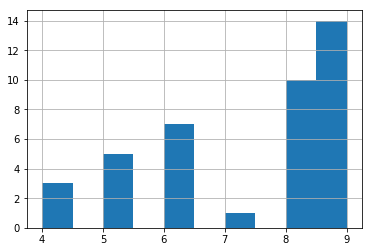

In [20]:
training_data_df[BEST_EPOCH].hist()

In [21]:
training_data_df[TOTAL_DURATION].describe()

count      40.000000
mean     2745.575000
std       130.976586
min      2604.000000
25%      2618.750000
50%      2740.000000
75%      2866.000000
max      2931.000000
Name: Total_Duration(s), dtype: float64

In [22]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
9,4.0,0.915370,0.001329,0.914400,0.914614,0.914881,0.915636,0.917320
8,4.0,0.914942,0.001598,0.912597,0.914590,0.915587,0.915939,0.915996
5,4.0,0.914590,0.002611,0.912052,0.913088,0.914081,0.915583,0.918148
0,4.0,0.913979,0.003163,0.909319,0.913356,0.915288,0.915911,0.916023
6,4.0,0.913919,0.004817,0.908954,0.911712,0.913115,0.915322,0.920492
2,4.0,0.913388,0.002739,0.910000,0.911966,0.913567,0.914989,0.916416
3,4.0,0.912934,0.000868,0.912166,0.912219,0.912835,0.913550,0.913901
7,4.0,0.912555,0.003168,0.908095,0.911749,0.913292,0.914098,0.915542
1,4.0,0.912092,0.001672,0.910414,0.911148,0.911806,0.912750,0.914343


In [23]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,40.0,0.913456,0.002851,0.000451,0.912544,0.914368


In [24]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
glove,40,0.913456,0.002851,0.000451,0.912572,0.914339


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING_DIMENSION)

Overall model F( 0, 39) =  nan, p =  nan
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 29 Sep 2019   Prob (F-statistic):                nan
Time:                        11:42:36   Log-Likelihood:                 178.15
No. Observations:                  40   AIC:                            -354.3
Df Residuals:                      39   BIC:                            -352.6
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


ValueError: must have at least one row in constraint matrix